In [107]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile

sys.path.insert(0, './XSpecT/')
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
import XSpect.XSpect_PostProcessing
import XSpect.XSpect_Diagnostics

import inspect

### Define object inspection function

In [4]:
def object_inspector(data_object, verbose=False):
    if verbose==True:
        print("------ ATTRIBUTE LIST ------")
        for x in dir(data_object):
            print(x)
        print("----- METHODS -----")
        for method in inspect.getmembers(data_object, predicate=inspect.ismethod):
            print(method)
        print("----- ATTRIBUTES -----")
        for key, value in vars(data_object).items():
            print(key, ":", value)
    if verbose==False:
        print("----- METHODS -----")
        for method in inspect.getmembers(data_object, predicate=inspect.ismethod):
            print(method)
        print("----- ATTRIBUTES -----")
        for key, value in vars(data_object).items():
            print(key, ":", value)

### Define and create Experiment and XES objects

In [5]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=24, hutch='xcs', experiment_id='xcs100861524')

In [9]:
object_inspector(xes_experiment)

----- METHODS -----
('__init__', <bound method spectroscopy_experiment.__init__ of <XSpect.XSpect_Analysis.spectroscopy_experiment object at 0x7fbd1c0f6700>>)
('add_detector', <bound method spectroscopy_experiment.add_detector of <XSpect.XSpect_Analysis.spectroscopy_experiment object at 0x7fbd1c0f6700>>)
('get_experiment_directory', <bound method experiment.get_experiment_directory of <XSpect.XSpect_Analysis.spectroscopy_experiment object at 0x7fbd1c0f6700>>)
----- ATTRIBUTES -----
lcls_run : 24
hutch : xcs
experiment_id : xcs100861524
experiment_directory : /sdf/data/lcls/ds/xcs/xcs100861524/hdf5/smalldata


In [10]:
xes = XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['epics/ccm_E','epicsUser/ccm_E_setpoint','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay', 'ipm4/sum','tt/AMPL'] 
names=['ccm','ccm_E_setpoint','time_tool_correction','lxt_ttc','encoder','ipm', 'time_tool_ampl']
xes.key_epix=[r'epix_2/ROI_0_area']
xes.friendly_name_epix=['epix']
xes.set_key_aliases(keys,names)
xes.lxt_key=None

In [11]:
xes.mintime=-10
xes.maxtime=70
xes.numpoints=25
xes.time_bins=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)

In [12]:
## Set an ROI (K alpha)
xes.rois=[[95,125]]
#xes.angle=1
#xes.transpose=True

In [13]:
## Set filters
xes.adu_cutoff=3.0
xes.add_filter('xray','ipm',200.0E3)
xes.add_filter('simultaneous','ipm',200.0E3)
xes.add_filter('simultaneous','time_tool_ampl',0.05)

In [14]:
object_inspector(xes)

----- METHODS -----
('__init__', <bound method XESBatchAnalysisRotation.__init__ of <XSpect.XSpect_Controller.XESBatchAnalysisRotation object at 0x7fbcdcdd4be0>>)
('add_filter', <bound method BatchAnalysis.add_filter of <XSpect.XSpect_Controller.XESBatchAnalysisRotation object at 0x7fbcdcdd4be0>>)
('aggregate_statistics', <bound method BatchAnalysis.aggregate_statistics of <XSpect.XSpect_Controller.XESBatchAnalysisRotation object at 0x7fbcdcdd4be0>>)
('append_arbitrary_filtering', <bound method XESBatchAnalysisRotation.append_arbitrary_filtering of <XSpect.XSpect_Controller.XESBatchAnalysisRotation object at 0x7fbcdcdd4be0>>)
('break_into_shot_ranges', <bound method BatchAnalysis.break_into_shot_ranges of <XSpect.XSpect_Controller.XESBatchAnalysisRotation object at 0x7fbcdcdd4be0>>)
('hit_find', <bound method XESBatchAnalysisRotation.hit_find of <XSpect.XSpect_Controller.XESBatchAnalysisRotation object at 0x7fbcdcdd4be0>>)
('parse_run_shots', <bound method BatchAnalysis.parse_run_shots

### How the primary_analysis_parallel_range runs

- This method is from the parent `BatchAnalysis` class
- Chunks the files into shot ranges
- Sets up parallelization
- Loops using `primary_analysis_range` from `XESBatchAnalysisRotation` class, which calls `primary_analysis` (also from `XESBatchAnalysisRotation`)
- Unclear how to "walk through" each analysis step with parallelization. Skip parallelization for now.
- Also don't break shots into runs to keep things simple

### Individual Analysis Steps

In [26]:
# Use only for the first 5000 shots to limit the size of object in memory
f=XSpect.XSpect_Analysis.spectroscopy_run(xes_experiment, 306, verbose=False, end_index=5000)

In [27]:
object_inspector(f)

----- METHODS -----
('__init__', <bound method spectroscopy_run.__init__ of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('close_h5', <bound method spectroscopy_run.close_h5 of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_run_shot_properties', <bound method spectroscopy_run.get_run_shot_properties of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_scan_val', <bound method spectroscopy_run.get_scan_val of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_key_delayed', <bound method spectroscopy_run.load_run_key_delayed of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_keys', <bound method spectroscopy_run.load_run_keys of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_sum_run_scattering', <bound method spectroscopy_run.load_sum_run_scattering of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('p

In [33]:
f.load_run_keys(xes.keys,xes.friendly_names)
f.load_run_key_delayed(xes.key_epix,xes.friendly_name_epix,rois=xes.import_roi)
f.get_run_shot_properties()

In [34]:
object_inspector(f)

----- METHODS -----
('__init__', <bound method spectroscopy_run.__init__ of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('close_h5', <bound method spectroscopy_run.close_h5 of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_run_shot_properties', <bound method spectroscopy_run.get_run_shot_properties of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_scan_val', <bound method spectroscopy_run.get_scan_val of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_key_delayed', <bound method spectroscopy_run.load_run_key_delayed of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_keys', <bound method spectroscopy_run.load_run_keys of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_sum_run_scattering', <bound method spectroscopy_run.load_sum_run_scattering of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('p

In [38]:
analysis=XSpect.XSpect_Analysis.XESAnalysis()

In [46]:
analysis.pixels_to_patch=xes.pixels_to_patch
analysis.filter_detector_adu(f,'epix',adu_threshold=xes.adu_cutoff)

array([[[-0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       , -0.       , -0.       , ..., -0.       ,
          0.       ,  3.5082376],
        [ 0.       , -0.       , -0.       , ..., -0.       ,
         -0.       , -0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ..., -0.       ,
          0.       ,  0.       ],
        [-0.       , -0.       , -0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
         -0.       ,  0.       ],
        [ 0.       , -0.       , -0.       , ..., -0.       ,
         -0.       , -0.       ],
        [-0.       , -0.       ,  0.       , ...,  0.       ,
         -0.       , -0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ..., -0.       ,
         -0.       ,  0.       ],
        [ 0.

In [48]:
for fil in xes.filters:
    analysis.filter_shots(f,fil['FilterType'],fil['FilterKey'],fil['FilterThreshold'])

In [51]:
object_inspector(f)

----- METHODS -----
('__init__', <bound method spectroscopy_run.__init__ of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('close_h5', <bound method spectroscopy_run.close_h5 of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_run_shot_properties', <bound method spectroscopy_run.get_run_shot_properties of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_scan_val', <bound method spectroscopy_run.get_scan_val of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_key_delayed', <bound method spectroscopy_run.load_run_key_delayed of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_keys', <bound method spectroscopy_run.load_run_keys of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_sum_run_scattering', <bound method spectroscopy_run.load_sum_run_scattering of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('p

In [56]:
analysis.union_shots(f,'epix',['simultaneous','laser'])
analysis.separate_shots(f,'epix',['xray','laser'])

In [59]:
analysis.time_binning(f,xes.time_bins,lxt_key=xes.lxt_key)
analysis.union_shots(f,'timing_bin_indices',['simultaneous','laser'])
analysis.separate_shots(f,'timing_bin_indices',['xray','laser'])

In [64]:
analysis.reduce_detector_temporal(f,'epix_simultaneous_laser','timing_bin_indices_simultaneous_laser',average=False)
analysis.reduce_detector_temporal(f,'epix_xray_not_laser','timing_bin_indices_xray_not_laser',average=False)

In [66]:
analysis.reduce_detector_spatial(f,'epix_simultaneous_laser_time_binned', rois=xes.rois)
analysis.reduce_detector_spatial(f,'epix_xray_not_laser_time_binned', rois=xes.rois)

In [67]:
object_inspector(f)

----- METHODS -----
('__init__', <bound method spectroscopy_run.__init__ of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('close_h5', <bound method spectroscopy_run.close_h5 of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_run_shot_properties', <bound method spectroscopy_run.get_run_shot_properties of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_scan_val', <bound method spectroscopy_run.get_scan_val of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_key_delayed', <bound method spectroscopy_run.load_run_key_delayed of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_keys', <bound method spectroscopy_run.load_run_keys of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_sum_run_scattering', <bound method spectroscopy_run.load_sum_run_scattering of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('p

In [70]:
analysis.make_energy_axis(f,f.epix_xray_not_laser_time_binned_ROI_1.shape[1],d=xes.crystal_d_space,R=xes.crystal_radius,A=xes.crystal_detector_distance)

In [80]:
object_inspector(f)

----- METHODS -----
('__init__', <bound method spectroscopy_run.__init__ of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('close_h5', <bound method spectroscopy_run.close_h5 of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_run_shot_properties', <bound method spectroscopy_run.get_run_shot_properties of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('get_scan_val', <bound method spectroscopy_run.get_scan_val of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_key_delayed', <bound method spectroscopy_run.load_run_key_delayed of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_run_keys', <bound method spectroscopy_run.load_run_keys of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('load_sum_run_scattering', <bound method spectroscopy_run.load_sum_run_scattering of <XSpect.XSpect_Analysis.spectroscopy_run object at 0x7fbcdc128490>>)
('p

In [76]:
keys_to_save=['start_index','end_index','run_file','run_number','verbose','status','status_datetime','epix_xray_not_laser_time_binned_ROI_1','epix_simultaneous_laser_time_binned_ROI_1']
f.purge_all_keys(keys_to_save)

### Final data
- Looks like `primary_analysis` returns f to `primary_analysis_range` which returns object to `primary_analysis` as `result` which is appended to `analyzed_runs`list

In [82]:
xes.analyzed_runs = f

In [93]:
len(xes.analyzed_runs.epix_simultaneous_laser_time_binned_ROI_1[0,:])

700

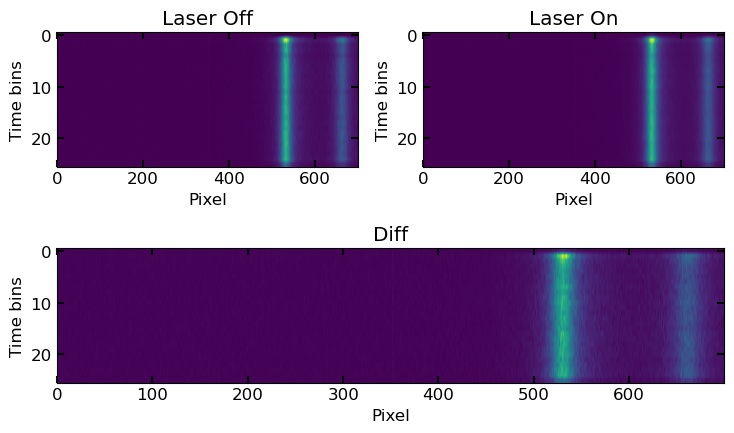

In [105]:
plt.subplot(2, 2, 1)
plt.imshow(xes.analyzed_runs.epix_xray_not_laser_time_binned_ROI_1, aspect='auto')
plt.xlabel("Pixel")
plt.ylabel("Time bins")
plt.title("Laser Off")


plt.subplot(2, 2, 2)
plt.imshow(xes.analyzed_runs.epix_simultaneous_laser_time_binned_ROI_1, aspect='auto')
plt.xlabel("Pixel")
plt.ylabel("Time bins")
plt.title("Laser On")

plt.subplot(2, 2, (3,4))
diff = xes.analyzed_runs.epix_simultaneous_laser_time_binned_ROI_1 - xes.analyzed_runs.epix_xray_not_laser_time_binned_ROI_1
plt.imshow(diff, aspect = 'auto')
plt.xlabel("Pixel")
plt.ylabel("Time bins")
plt.title("Diff")

plt.tight_layout()

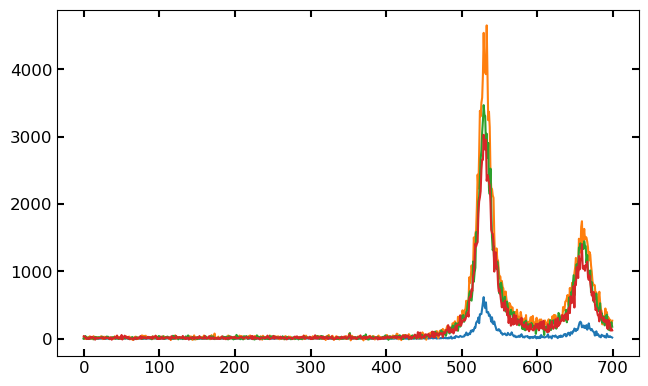

In [114]:
plt.plot(diff[0, :])
plt.plot(diff[1, :])
plt.plot(diff[2, :])
plt.plot(diff[3, :])